# 2-Qubit Quantum Teleportation with Noise

### Step 1: Define the Quantum Teleportation Circuit and Find the Fidelity of that 

In [1]:
# Two-Qubit Quantum State Teleportation — Modular and Idealized Simulation
# ------------------------------------------------------------------------
# Description:
# This script demonstrates the teleportation of a general two-qubit quantum state 
# using entangled resources and quantum gates under idealized conditions.
# The protocol uses statevector simulation (no actual measurements), and assumes
# Alice's measurement outcome is '00 00', so Bob doesn't apply any conditional logic.

# Key Concepts:
# - The sender (Alice) encodes a 2-qubit message on qubits 0 and 1.
# - Two Bell pairs are shared between Alice (qubits 2,3) and Bob (qubits 4,5).
# - Entangling operations simulate Bell-basis projection (without measurement).
# - Bob's qubits receive the original message via gate operations conditioned 
#   on assumed classical outcomes.
# - Fidelity is computed between the sent and received two-qubit states.

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity


def prepare_two_qubit_state(circuit, q0, q1):
    """
    Prepares a generic two-qubit quantum state with non-trivial amplitude and phase.
    This function uses Hadamard and T gates to introduce both superposition and
    relative phase between basis states, ensuring the teleportation is non-trivial.
    """
    circuit.h(q0)
    circuit.t(q0)
    circuit.h(q1)
    circuit.t(q1)


def create_bell_pair(circuit, a, b):
    """
    Entangles two qubits into a Bell state.
    Applies Hadamard to the first qubit and a CNOT to the second.
    This creates maximal entanglement between qubits `a` and `b`.
    """
    circuit.h(a)
    circuit.cx(a, b)


def simulate_two_qubit_teleportation():
    """
    Executes the teleportation process of a two-qubit state using ideal simulation.
    Includes all steps from state preparation to final fidelity evaluation.
    """
    # Allocate 6 qubits:
    # 0,1 = message qubits (Alice)
    # 2,3 = Alice’s halves of Bell pairs
    # 4,5 = Bob’s target qubits for receiving the message
    teleport_circuit = QuantumCircuit(6)

    # Step 1: Initialize Alice's message (an arbitrary 2-qubit quantum state)
    prepare_two_qubit_state(teleport_circuit, 0, 1)

    # Snapshot the complete system state to extract just Alice's message later
    original_state = Statevector.from_instruction(teleport_circuit)
    message_qubits = partial_trace(original_state, [2, 3, 4, 5])  # keep qubits 0 and 1

    # Step 2: Set up shared entanglement between Alice and Bob using two Bell pairs
    # Bell pair 1: qubit 2 (Alice) entangled with qubit 4 (Bob)
    # Bell pair 2: qubit 3 (Alice) entangled with qubit 5 (Bob)
    create_bell_pair(teleport_circuit, 2, 4)
    create_bell_pair(teleport_circuit, 3, 5)

    # Step 3: Alice entangles her message qubits with her halves of the Bell pairs
    # These CNOT+Hadamard operations prepare for Bell-basis measurement (not measured here)
    teleport_circuit.cx(0, 2)
    teleport_circuit.h(0)

    teleport_circuit.cx(1, 3)
    teleport_circuit.h(1)

    # Step 4: Bob applies deterministic corrections under the assumption
    # that Alice's classical measurement outcome was "00 00"
    # (In real implementation, Bob would apply corrections based on actual bits)
    teleport_circuit.cx(2, 4)
    teleport_circuit.cz(0, 4)

    teleport_circuit.cx(3, 5)
    teleport_circuit.cz(1, 5)

    # Step 5: Reconstruct the final state and extract Bob’s qubits (teleported output)
    final_state = Statevector.from_instruction(teleport_circuit)
    received_qubits = partial_trace(final_state, [0, 1, 2, 3])  # keep qubits 4 and 5

    # Step 6: Compare input vs output to verify if teleportation succeeded
    print("Alice's original message (Qubits 0 & 1):")
    print(message_qubits)

    print("\nBob's received state (Qubits 4 & 5):")
    print(received_qubits)

    # Calculate fidelity between original and teleported states
    fidelity = state_fidelity(message_qubits, received_qubits)
    print(f"\nTeleportation Fidelity: {fidelity:.6f}")


# Run the full teleportation protocol
simulate_two_qubit_teleportation()


Alice's original message (Qubits 0 & 1):
DensityMatrix([[0.25     +0.j       , 0.1767767-0.1767767j,
                0.1767767-0.1767767j, 0.       -0.25j     ],
               [0.1767767+0.1767767j, 0.25     +0.j       ,
                0.25     +0.j       , 0.1767767-0.1767767j],
               [0.1767767+0.1767767j, 0.25     +0.j       ,
                0.25     +0.j       , 0.1767767-0.1767767j],
               [0.       +0.25j     , 0.1767767+0.1767767j,
                0.1767767+0.1767767j, 0.25     +0.j       ]],
              dims=(2, 2))

Bob's received state (Qubits 4 & 5):
DensityMatrix([[0.25     +0.j       , 0.1767767-0.1767767j,
                0.1767767-0.1767767j, 0.       -0.25j     ],
               [0.1767767+0.1767767j, 0.25     +0.j       ,
                0.25     +0.j       , 0.1767767-0.1767767j],
               [0.1767767+0.1767767j, 0.25     +0.j       ,
                0.25     +0.j       , 0.1767767-0.1767767j],
               [0.       +0.25j     , 0.176776

### Step 2: Apply Noise Channels

In [3]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit_aer.library import SaveDensityMatrix


def prepare_two_qubit_state(circuit, q0, q1):
    """Applies superposition and phase to two message qubits."""
    circuit.h(q0)
    circuit.t(q0)
    circuit.h(q1)
    circuit.t(q1)


def create_bell_pair(circuit, a, b):
    """Entangles qubit a and b into a Bell state."""
    circuit.h(a)
    circuit.cx(a, b)


def simulate_noisy_teleportation_amplitude_damping(gamma=0.3):
    """
    Runs teleportation protocol for a two-qubit state under amplitude damping noise.
    Returns the fidelity between the initial message and the received (noisy) state.
    """
    # Create amplitude damping error and noise model
    noise_model = NoiseModel()
    amp_damp = amplitude_damping_error(gamma)
    noise_model.add_all_qubit_quantum_error(amp_damp, ['h', 't', 'x', 'z', 'id'])

    # Initialize quantum circuit
    teleport_circuit = QuantumCircuit(6)

    # Step 1: Prepare arbitrary 2-qubit input
    prepare_two_qubit_state(teleport_circuit, 0, 1)

    # Save the initial statevector before any entanglement
    original_state = Statevector.from_instruction(teleport_circuit)
    message_qubits = partial_trace(original_state, [2, 3, 4, 5])

    # Step 2: Create Bell pairs
    create_bell_pair(teleport_circuit, 2, 4)
    create_bell_pair(teleport_circuit, 3, 5)

    # Step 3: Entangle message qubits with ancillas (simulate Bell measurement)
    teleport_circuit.cx(0, 2)
    teleport_circuit.h(0)
    teleport_circuit.cx(1, 3)
    teleport_circuit.h(1)

    # Step 4: Apply correction assuming classical outcome "00 00"
    teleport_circuit.cx(2, 4)
    teleport_circuit.cz(0, 4)
    teleport_circuit.cx(3, 5)
    teleport_circuit.cz(1, 5)

    # Save the noisy density matrix for output analysis
    teleport_circuit.save_density_matrix()

    # Step 5: Simulate with noise
    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    result = simulator.run(teleport_circuit).result()
    noisy_dm = result.data(0)['density_matrix']

    # Step 6: Extract Bob’s qubits (4 and 5)
    received_qubits = partial_trace(noisy_dm, [0, 1, 2, 3])

    # Step 7: Fidelity comparison
    fidelity = state_fidelity(message_qubits, received_qubits)

    # Print results
    print(f"Fidelity under amplitude damping (γ = {gamma}): {fidelity:.4f}")
    return gamma, fidelity


# Run simulation for single gamma value (0.3 by default)
simulate_noisy_teleportation_amplitude_damping(gamma=0.3)


Fidelity under amplitude damping (γ = 0.3): 0.4970


(0.3, 0.496999213512653)

### Step 3: Fidelity Calculation and Plotting

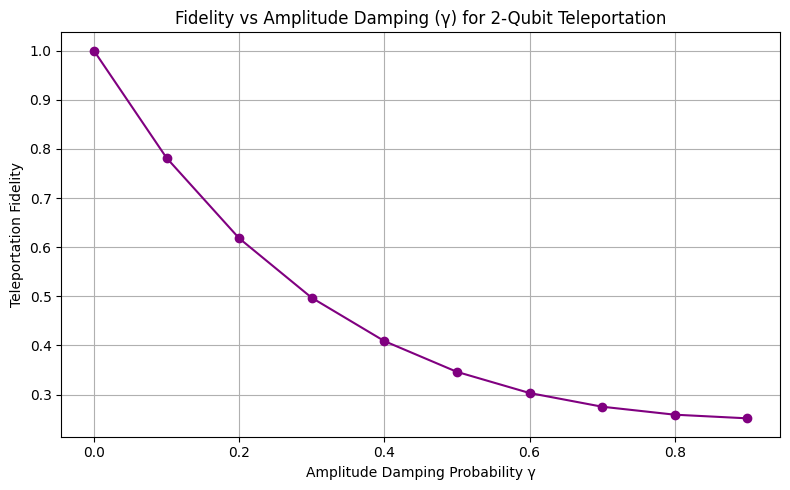

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit_aer.library import SaveDensityMatrix


def prepare_two_qubit_state(circuit, q0, q1):
    circuit.h(q0)
    circuit.t(q0)
    circuit.h(q1)
    circuit.t(q1)


def create_bell_pair(circuit, a, b):
    circuit.h(a)
    circuit.cx(a, b)


def simulate_noisy_teleportation_amplitude_damping(gamma):
    noise_model = NoiseModel()
    amp_damp = amplitude_damping_error(gamma)
    noise_model.add_all_qubit_quantum_error(amp_damp, ['h', 't', 'x', 'z', 'id'])

    teleport_circuit = QuantumCircuit(6)
    prepare_two_qubit_state(teleport_circuit, 0, 1)

    original_state = Statevector.from_instruction(teleport_circuit)
    message_qubits = partial_trace(original_state, [2, 3, 4, 5])

    create_bell_pair(teleport_circuit, 2, 4)
    create_bell_pair(teleport_circuit, 3, 5)

    teleport_circuit.cx(0, 2)
    teleport_circuit.h(0)
    teleport_circuit.cx(1, 3)
    teleport_circuit.h(1)

    teleport_circuit.cx(2, 4)
    teleport_circuit.cz(0, 4)
    teleport_circuit.cx(3, 5)
    teleport_circuit.cz(1, 5)

    teleport_circuit.save_density_matrix()

    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    result = simulator.run(teleport_circuit).result()
    noisy_dm = result.data(0)['density_matrix']
    received_qubits = partial_trace(noisy_dm, [0, 1, 2, 3])

    return state_fidelity(message_qubits, received_qubits)


# Define gamma values to sweep across
gamma_values = np.linspace(0, 0.9, 10)
fidelities = [simulate_noisy_teleportation_amplitude_damping(g) for g in gamma_values]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(gamma_values, fidelities, marker='o', color='purple')
plt.title('Fidelity vs Amplitude Damping (γ) for 2-Qubit Teleportation')
plt.xlabel('Amplitude Damping Probability γ')
plt.ylabel('Teleportation Fidelity')
plt.grid(True)
plt.tight_layout()
plt.show()


Fidelity under depolarizing noise (p = 0.3): 0.450912


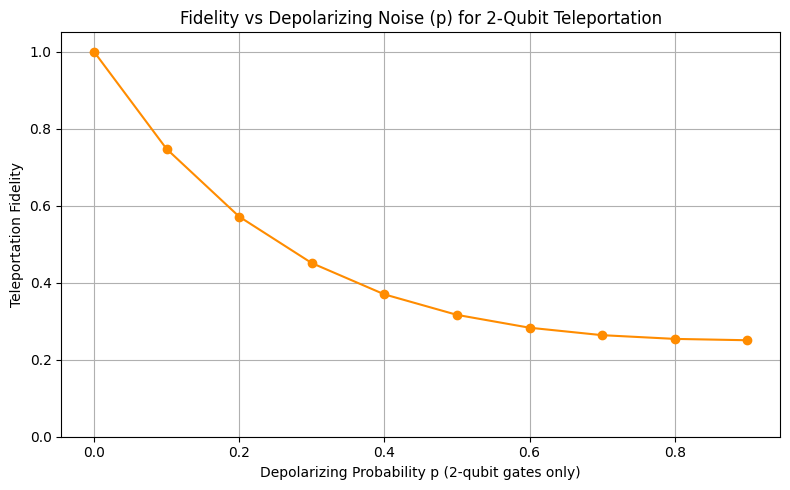

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit_aer.library import SaveDensityMatrix


def prepare_two_qubit_state(circuit, q0, q1):
    circuit.h(q0)
    circuit.t(q0)
    circuit.h(q1)
    circuit.t(q1)


def create_bell_pair(circuit, a, b):
    circuit.h(a)
    circuit.cx(a, b)


def simulate_2qubit_teleportation_depolarizing(p):
    noise_model = NoiseModel()
    depol_error = depolarizing_error(p, 2)
    noise_model.add_all_qubit_quantum_error(depol_error, ['cx'])

    qc = QuantumCircuit(6)
    prepare_two_qubit_state(qc, 0, 1)

    original_state = Statevector.from_instruction(qc)
    message_qubits = partial_trace(original_state, [2, 3, 4, 5])

    create_bell_pair(qc, 2, 4)
    create_bell_pair(qc, 3, 5)

    qc.cx(0, 2)
    qc.h(0)
    qc.cx(1, 3)
    qc.h(1)

    qc.cx(2, 4)
    qc.cz(0, 4)
    qc.cx(3, 5)
    qc.cz(1, 5)

    qc.save_density_matrix()

    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    result = simulator.run(qc).result()
    noisy_dm = result.data(0)['density_matrix']
    output_state = partial_trace(noisy_dm, [0, 1, 2, 3])

    return state_fidelity(message_qubits, output_state)


# Run once for p = 0.3
fidelity_p03 = simulate_2qubit_teleportation_depolarizing(0.3)
print(f"Fidelity under depolarizing noise (p = 0.3): {fidelity_p03:.6f}")

# Run for a range of p values
p_values = np.linspace(0, 0.9, 10)
fidelities = [simulate_2qubit_teleportation_depolarizing(p) for p in p_values]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(p_values, fidelities, marker='o', color='darkorange')
plt.title('Fidelity vs Depolarizing Noise (p) for 2-Qubit Teleportation')
plt.xlabel('Depolarizing Probability p (2-qubit gates only)')
plt.ylabel('Teleportation Fidelity')
plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
#plt.savefig("depolarizing_fidelity_plot.png", dpi=300)  # optional: save to file
plt.show()


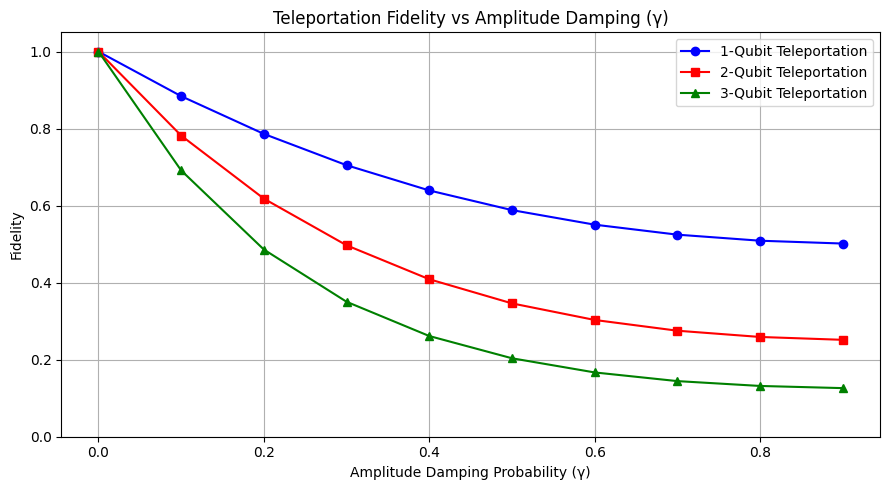

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit_aer.library import SaveDensityMatrix


def create_amplitude_damping_noise(gamma):
    noise_model = NoiseModel()
    error = amplitude_damping_error(gamma)
    noise_model.add_all_qubit_quantum_error(error, ['h', 't', 'x', 'z', 'id'])
    return noise_model


def simulate_teleportation(n_qubits, gamma):
    """
    Simulate n-qubit teleportation (n = 1, 2, or 3) under amplitude damping.
    Returns fidelity between original and received message state.
    """
    noise_model = create_amplitude_damping_noise(gamma)

    total_qubits = 3 * n_qubits  # message + entangle + Bob
    qc = QuantumCircuit(total_qubits)

    # Step 1: Prepare message on qubits 0 to n-1
    for i in range(n_qubits):
        qc.h(i)
        qc.t(i)

    # Save original state
    original_state = Statevector.from_instruction(qc)
    message_qubits = partial_trace(original_state, list(range(n_qubits, total_qubits)))

    # Step 2: Create Bell pairs
    for i in range(n_qubits):
        alice = n_qubits + i
        bob = 2 * n_qubits + i
        qc.h(alice)
        qc.cx(alice, bob)

    # Step 3: Entangle message with Alice's Bell halves
    for i in range(n_qubits):
        msg = i
        alice = n_qubits + i
        qc.cx(msg, alice)
        qc.h(msg)

    # Step 4: Apply Bob's correction assuming outcome "00...0"
    for i in range(n_qubits):
        msg = i
        alice = n_qubits + i
        bob = 2 * n_qubits + i
        qc.cx(alice, bob)
        qc.cz(msg, bob)

    qc.save_density_matrix()

    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    result = simulator.run(qc).result()
    noisy_dm = result.data(0)['density_matrix']
    bob_qubits = list(range(2 * n_qubits, 3 * n_qubits))
    keep = bob_qubits
    discard = list(set(range(total_qubits)) - set(keep))
    output_state = partial_trace(noisy_dm, discard)

    return state_fidelity(message_qubits, output_state)


# Sweep gamma values
gamma_values = np.linspace(0, 0.9, 10)
fidelities_1q = [simulate_teleportation(1, g) for g in gamma_values]
fidelities_2q = [simulate_teleportation(2, g) for g in gamma_values]
fidelities_3q = [simulate_teleportation(3, g) for g in gamma_values]

# Plot
plt.figure(figsize=(9, 5))
plt.plot(gamma_values, fidelities_1q, 'o-', label='1-Qubit Teleportation', color='blue')
plt.plot(gamma_values, fidelities_2q, 's-', label='2-Qubit Teleportation', color='red')
plt.plot(gamma_values, fidelities_3q, '^-', label='3-Qubit Teleportation', color='green')

plt.title('Teleportation Fidelity vs Amplitude Damping (γ)')
plt.xlabel('Amplitude Damping Probability (γ)')
plt.ylabel('Fidelity')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("teleportation_fidelity_comparison.png", dpi=300)
plt.show()


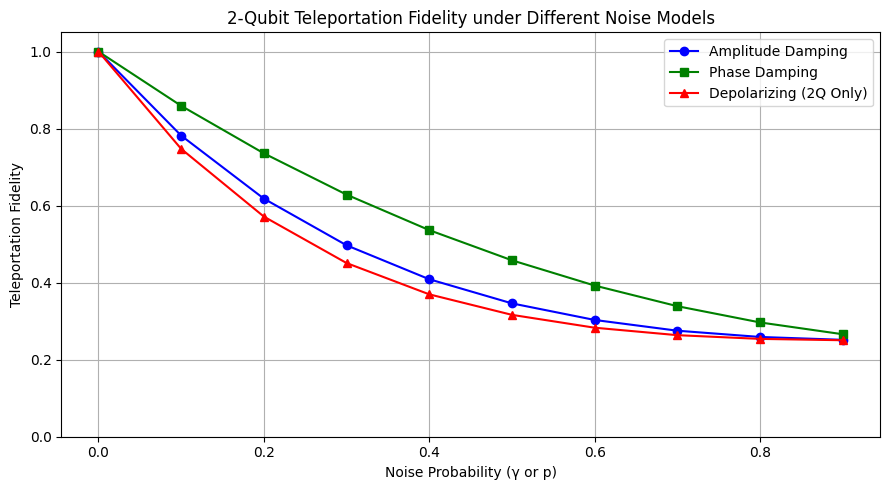

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, phase_damping_error, depolarizing_error
from qiskit.quantum_info import Statevector, partial_trace, state_fidelity
from qiskit_aer.library import SaveDensityMatrix


def prepare_two_qubit_state(circuit, q0, q1):
    circuit.h(q0)
    circuit.t(q0)
    circuit.h(q1)
    circuit.t(q1)


def create_bell_pair(circuit, a, b):
    circuit.h(a)
    circuit.cx(a, b)


def simulate_2qubit_teleportation_with_noise(p, noise_type):
    noise_model = NoiseModel()

    if noise_type == "amplitude":
        error = amplitude_damping_error(p)
        noise_model.add_all_qubit_quantum_error(error, ['h', 't', 'x', 'z', 'id'])

    elif noise_type == "phase":
        error = phase_damping_error(p)
        noise_model.add_all_qubit_quantum_error(error, ['h', 't', 'x', 'z', 'id'])

    elif noise_type == "depolarizing":
        error = depolarizing_error(p, 2)
        noise_model.add_all_qubit_quantum_error(error, ['cx'])

    else:
        raise ValueError("Unknown noise type")

    qc = QuantumCircuit(6)
    prepare_two_qubit_state(qc, 0, 1)

    original_state = Statevector.from_instruction(qc)
    message_qubits = partial_trace(original_state, [2, 3, 4, 5])

    create_bell_pair(qc, 2, 4)
    create_bell_pair(qc, 3, 5)

    qc.cx(0, 2)
    qc.h(0)
    qc.cx(1, 3)
    qc.h(1)

    qc.cx(2, 4)
    qc.cz(0, 4)
    qc.cx(3, 5)
    qc.cz(1, 5)

    qc.save_density_matrix()

    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    result = simulator.run(qc).result()
    noisy_dm = result.data(0)['density_matrix']
    output_state = partial_trace(noisy_dm, [0, 1, 2, 3])

    return state_fidelity(message_qubits, output_state)


# Define sweep range
p_values = np.linspace(0, 0.9, 10)

# Simulate all 3 noise types
fidelities_amp = [simulate_2qubit_teleportation_with_noise(p, "amplitude") for p in p_values]
fidelities_phase = [simulate_2qubit_teleportation_with_noise(p, "phase") for p in p_values]
fidelities_depol = [simulate_2qubit_teleportation_with_noise(p, "depolarizing") for p in p_values]

# Plot all
plt.figure(figsize=(9, 5))
plt.plot(p_values, fidelities_amp, 'o-', color='blue', label='Amplitude Damping')
plt.plot(p_values, fidelities_phase, 's-', color='green', label='Phase Damping')
plt.plot(p_values, fidelities_depol, '^-', color='red', label='Depolarizing (2Q Only)')

plt.title('2-Qubit Teleportation Fidelity under Different Noise Models')
plt.xlabel('Noise Probability (γ or p)')
plt.ylabel('Teleportation Fidelity')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("2qubit_noise_comparison.png", dpi=300)  # Optional: Save plot
plt.show()
